<a href="https://colab.research.google.com/github/khoji-code/Data-Science-AI-for-Business-Portfolio/blob/main/Projects/Supply_Chain_Forecasting_with_Graph_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supply Chain Forecasting with Graph Neural Networks

***

### **Project Overview**

* **Goal:** To build a Graph Neural Network (GNN) model to forecast sales and production units for a supply chain network.
* **Dataset:** Uses multiple CSV files representing supply chain data, including node information (products), edge connections (plant, product group, etc.), and temporal data (sales and production orders).
* **Methodology:** The project involves extensive data loading and preprocessing to construct a heterogeneous graph. It then uses a GNN combined with an LSTM (GNN-LSTM) to learn from both the graph structure and time-series data. This model's performance is benchmarked against a standard LSTM and a simple moving average.
* **Key Insights:** The GNN-LSTM model significantly outperforms the baseline LSTM, demonstrating the value of incorporating graph structure in forecasting tasks. The model successfully captures complex supply chain dynamics to provide more accurate predictions.

***

### **Purpose**

* **Improve Forecasting Accuracy:** To leverage the relational structure of the supply chain network (how products and locations are connected) to create more accurate sales and production forecasts than traditional time-series models.
* **Advanced Supply Chain Modeling:** To demonstrate the application of Graph Neural Networks for complex, interconnected systems, providing a more holistic view of supply chain dynamics.
* **Benchmark and Validate:** To empirically show that a GNN-based approach offers superior predictive power compared to a standard LSTM model, thus validating its use for similar forecasting problems.

### Dataset:
https://github.com/ciol-researchlab/SupplyGraph/tree/main

## SETUP AND LIBRARY IMPORTS

In [ ]:
# Installing
!pip install -q torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.3.0+cu118.html

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

# PyTorch and PyTorch Geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import GATConv, HeteroConv # Import HeteroConv
from torch.utils.data import TensorDataset, DataLoader

# Scikit-learn for preprocessing and evaluation
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Configuration and Initial Setup ---
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

# For reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"--- Using device: {DEVICE} ---")

/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.12/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _Z

--- Using device: cpu ---


## DATA LOADING AND PREPARATION

In [ ]:
file_paths = {
    "nodes_index": "/content/drive/MyDrive/raw/NodesIndex.csv",
    "node_types": "/content/drive/MyDrive/raw/Node Types (Product Group and Subgroup).csv",
    "edges_plant": "/content/drive/MyDrive/raw/Edges (Plant)(1).csv",
    "edges_pg": "/content/drive/MyDrive/raw/Edges (Product Group)(1).csv",
    "edges_psg": "/content/drive/MyDrive/raw/Edges (Product Sub-Group)(1).csv",
    "edges_sl": "/content/drive/MyDrive/raw/Edges (Storage Location)(1).csv",
    "temporal_sales_units": "/content/drive/MyDrive/raw/Sales Order.csv",
    "temporal_production_units": "/content/drive/MyDrive/raw/Production (1).csv",
}

# --- Load all datasets ---
data = {}
for name, path in file_paths.items():
    try:
        data[name] = pd.read_csv(path)
        print(f"Successfully loaded {name} from {path}")
    except FileNotFoundError:
        print(f"ERROR: Could not find file {path}. Please ensure it is in the correct directory.")
        if name in ["nodes_index", "node_types", "temporal_sales_units", "temporal_production_units"]:
             exit()

# --- Data Cleaning and Standardization ---
nodes_df = pd.merge(data['nodes_index'], data['node_types'], on='Node', how='left')
nodes_df.rename(columns={'Node': 'node_name', 'NodeIndex': 'node_id', 'Group': 'group', 'Sub-Group': 'sub_group'}, inplace=True)
nodes_df = nodes_df.drop_duplicates(subset=['node_id']).set_index('node_id').sort_index()
num_nodes = len(nodes_df)
print(f"\nTotal unique nodes: {num_nodes}")

def preprocess_temporal_df(df, value_name):
    df = df.copy()
    df.columns = df.columns.str.replace(r'\.1$', '', regex=True)
    if 'Date' not in df.columns:
        df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    melted_df = df.melt(id_vars='Date', var_name='node_name', value_name=value_name)
    return melted_df

sales_df = preprocess_temporal_df(data['temporal_sales_units'], 'sales')
prod_df = preprocess_temporal_df(data['temporal_production_units'], 'production')

temporal_df = pd.merge(sales_df, prod_df, on=['Date', 'node_name'], how='outer')
node_name_to_id = nodes_df.reset_index()[['node_name', 'node_id']].drop_duplicates()
temporal_df = pd.merge(temporal_df, node_name_to_id, on='node_name', how='inner')

print("Aggregating temporal data to handle duplicates...")
temporal_df = temporal_df.groupby(['Date', 'node_id', 'node_name'])[['sales', 'production']].sum().reset_index()
temporal_df = temporal_df.sort_values(['Date', 'node_id']).reset_index(drop=True)
temporal_df.fillna(0, inplace=True)

print("Temporal data shape after processing:", temporal_df.shape)
print(temporal_df.head())


Successfully loaded nodes_index from /content/drive/MyDrive/raw/NodesIndex.csv
Successfully loaded node_types from /content/drive/MyDrive/raw/Node Types (Product Group and Subgroup).csv
Successfully loaded edges_plant from /content/drive/MyDrive/raw/Edges (Plant)(1).csv
Successfully loaded edges_pg from /content/drive/MyDrive/raw/Edges (Product Group)(1).csv
Successfully loaded edges_psg from /content/drive/MyDrive/raw/Edges (Product Sub-Group)(1).csv
Successfully loaded edges_sl from /content/drive/MyDrive/raw/Edges (Storage Location)(1).csv
Successfully loaded temporal_sales_units from /content/drive/MyDrive/raw/Sales Order.csv
Successfully loaded temporal_production_units from /content/drive/MyDrive/raw/Production (1).csv

Total unique nodes: 40
Aggregating temporal data to handle duplicates...
Temporal data shape after processing: (8840, 5)
        Date  node_id   node_name    sales  production
0 2023-01-01        0  SOS008L02P   1355.0        1008
1 2023-01-01        1  SOS005L04P

## EXPLORATORY DATA ANALYSIS (EDA)

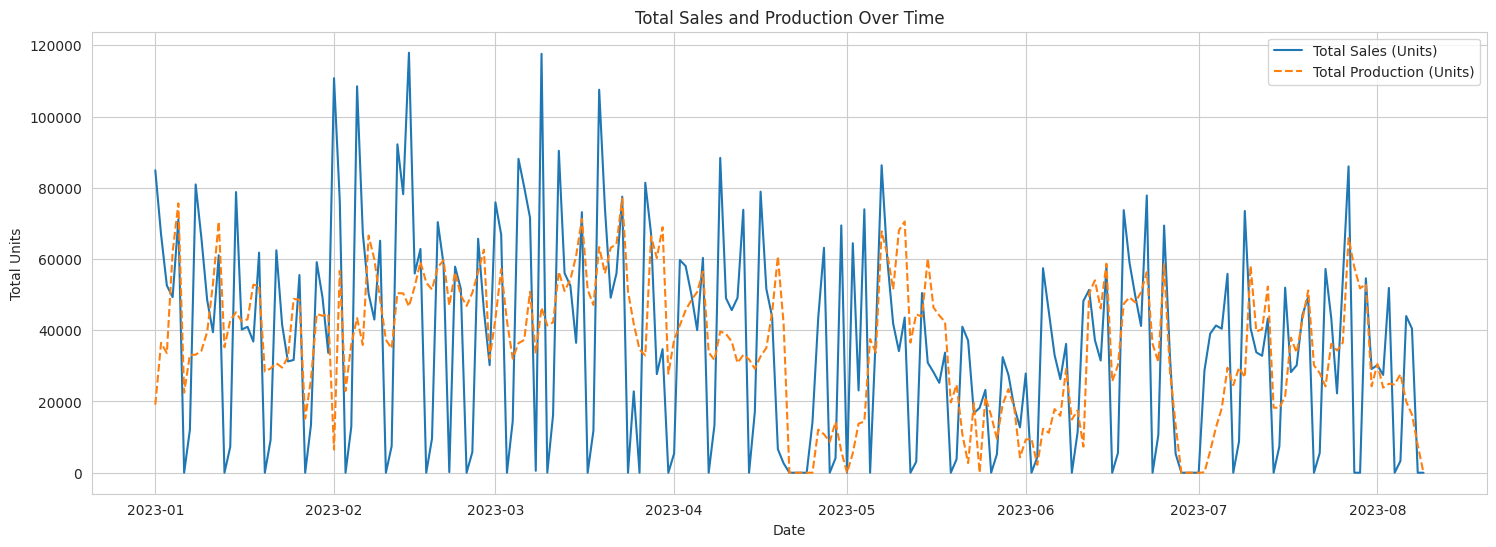

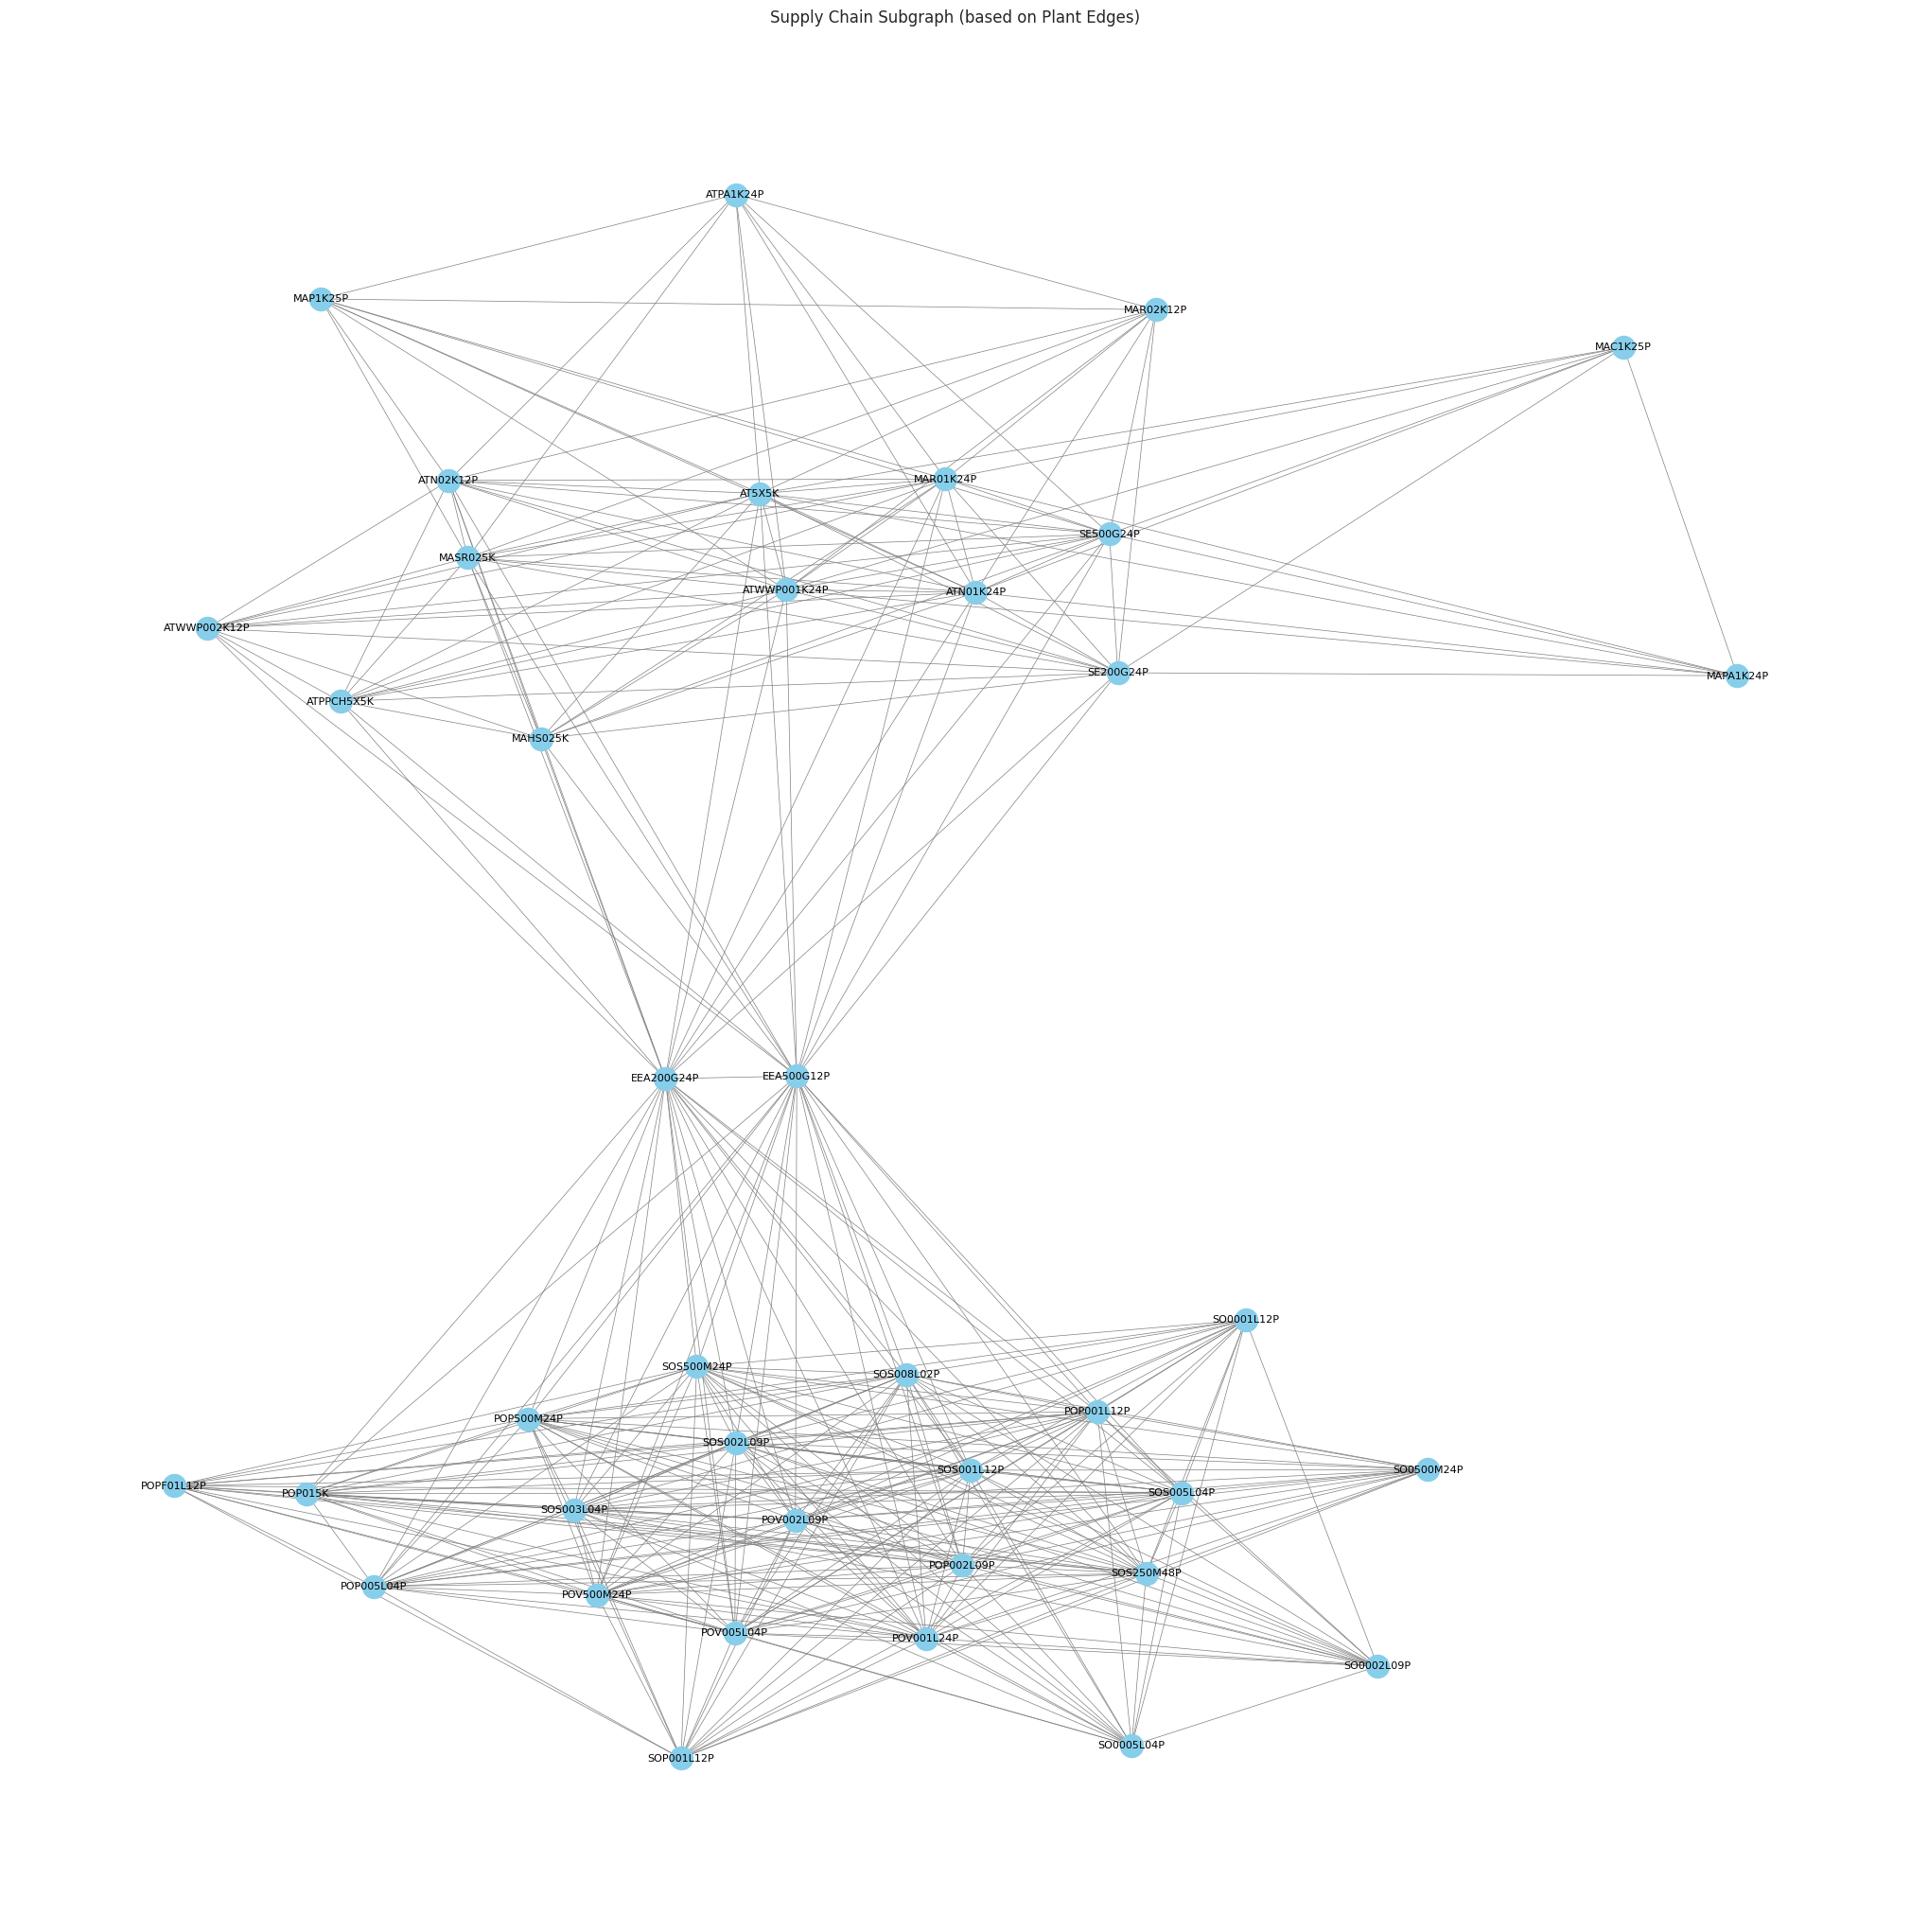

Graph Info: 40 nodes, 360 edges


In [ ]:
plt.figure(figsize=(18, 6))
temporal_agg = temporal_df.groupby('Date')[['sales', 'production']].sum()
plt.plot(temporal_agg.index, temporal_agg['sales'], label='Total Sales (Units)')
plt.plot(temporal_agg.index, temporal_agg['production'], label='Total Production (Units)', linestyle='--')
plt.title('Total Sales and Production Over Time')
plt.xlabel('Date')
plt.ylabel('Total Units')
plt.legend()
plt.show()

edge_list_plant = data['edges_plant'][['node1', 'node2']].values
G = nx.Graph()
G.add_nodes_from(nodes_df.index)
G.add_edges_from(edge_list_plant)

largest_cc = max(nx.connected_components(G), key=len)
subgraph = G.subgraph(list(largest_cc)[:50])

plt.figure(figsize=(20, 20))
pos = nx.spring_layout(subgraph, k=0.8)
labels = {node: nodes_df.loc[node, 'node_name'] for node in subgraph.nodes()}
nx.draw(subgraph, pos, labels=labels, with_labels=True, node_size=300, node_color='skyblue',
        font_size=8, edge_color='gray', width=0.5)
plt.title('Supply Chain Subgraph (based on Plant Edges)')
plt.show()

print(f"Graph Info: {len(G.nodes())} nodes, {len(G.edges())} edges")

## FEATURE ENGINEERING & GRAPH CONSTRUCTION

In [ ]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(nodes_df[['group', 'sub_group']].fillna('Unknown'))
static_node_features = torch.tensor(encoded_features, dtype=torch.float)
print("Static node feature shape:", static_node_features.shape)

graph_data = HeteroData()
graph_data['product'].x = static_node_features
graph_data['product'].num_nodes = num_nodes

def add_edges(data_obj, edge_df, relation_name):
    if 'node1' in edge_df.columns and 'node2' in edge_df.columns:
        edge_index = torch.tensor(edge_df[['node1', 'node2']].values, dtype=torch.long).t().contiguous()
        data_obj['product', relation_name, 'product'].edge_index = edge_index
    else:
        print(f"Warning: Could not find 'node1' and 'node2' columns in edge file for '{relation_name}'. Skipping.")

if 'edges_plant' in data:
    add_edges(graph_data, data['edges_plant'], 'connected_by_plant')
if 'edges_pg' in data:
    add_edges(graph_data, data['edges_pg'], 'in_product_group')
if 'edges_psg' in data:
    add_edges(graph_data, data['edges_psg'], 'in_product_sub_group')
if 'edges_sl' in data:
    add_edges(graph_data, data['edges_sl'], 'in_storage_location')

print("\nPyG HeteroData object created:")
print(graph_data)

target_feature = 'sales'
features_to_scale = ['sales', 'production']

pivot_df = temporal_df.pivot(index='Date', columns='node_id', values=features_to_scale)
pivot_df.columns = ['_'.join(map(str, col)) for col in pivot_df.columns]
pivot_df = pivot_df.sort_index()
pivot_df.fillna(0, inplace=True)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)
scaled_df = pd.DataFrame(scaled_data, index=pivot_df.index, columns=pivot_df.columns)

def create_sequences(data, seq_length, forecast_horizon):
    xs, ys = [], []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length:i + seq_length + forecast_horizon]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 14
FORECAST_HORIZON = 1
num_features_per_node = len(features_to_scale)

reshaped_data = scaled_df.values.reshape(len(scaled_df), num_nodes, num_features_per_node)
X, y_full = create_sequences(reshaped_data, SEQ_LENGTH, FORECAST_HORIZON)
y = y_full[:, 0, :, 0]

total_samples = len(X)
train_size = int(total_samples * 0.7)
val_size = int(total_samples * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

print(f"\nData shapes:\nX_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

def to_tensor(arr):
    return torch.tensor(arr, dtype=torch.float)

train_loader = DataLoader(TensorDataset(to_tensor(X_train), to_tensor(y_train)), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(to_tensor(X_val), to_tensor(y_val)), batch_size=32)
test_loader = DataLoader(TensorDataset(to_tensor(X_test), to_tensor(y_test)), batch_size=32)

Static node feature shape: torch.Size([40, 24])

PyG HeteroData object created:
HeteroData(
  product={
    x=[40, 24],
    num_nodes=40,
  },
  (product, connected_by_plant, product)={ edge_index=[2, 1647] },
  (product, in_product_group, product)={ edge_index=[2, 188] },
  (product, in_product_sub_group, product)={ edge_index=[2, 52] },
  (product, in_storage_location, product)={ edge_index=[2, 3046] }
)

Data shapes:
X_train: (144, 14, 40, 2), y_train: (144, 40)
X_val: (31, 14, 40, 2), y_val: (31, 40)
X_test: (32, 14, 40, 2), y_test: (32, 40)


## MODEL ARCHITECTURE (TEMPORAL GNN)

In [ ]:
class GNN_LSTM(nn.Module):
    """
    Graph Neural Network with LSTM for temporal processing.
    This model uses HeteroConv to manually define a GNN that processes spatial
    dependencies. The resulting sequence of graph embeddings is then fed into
    an LSTM to learn temporal patterns.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, metadata):
        super().__init__()

        # --- FIX: Manually define the HeteroConv layer instead of using to_hetero ---
        # This is a more robust way to build heterogeneous models.
        self.gnn = HeteroConv({
            # For each edge type, define a GATConv layer to be applied.
            # (-1, -1) allows the layer to handle different feature sizes for source/target nodes.
            edge_type: GATConv((-1, -1), hidden_channels, heads=2, concat=False)
            for edge_type in metadata[1] # metadata[1] contains the list of edge types
        }, aggr='sum')

        # The temporal part
        self.lstm = nn.LSTM(
            input_size=hidden_channels,
            hidden_size=hidden_channels,
            num_layers=2,
            batch_first=True,
            dropout=0.1
        )

        # Output layer
        self.linear = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_seq, static_features, edge_index_dict):
        # x_seq shape: (batch, seq_len, num_nodes, num_features)
        batch_size, seq_len, num_nodes, _ = x_seq.shape

        gnn_out_seq = []
        for t in range(seq_len):
            x_t = x_seq[:, t, :, :]

            batch_gnn_out = []
            for b in range(batch_size):
                current_features = torch.cat([static_features, x_t[b]], dim=1)
                gnn_input = {'product': current_features}

                # Apply the HeteroConv GNN
                h = self.gnn(gnn_input, edge_index_dict)
                batch_gnn_out.append(h['product'])

            gnn_out_t = torch.stack(batch_gnn_out)
            gnn_out_seq.append(gnn_out_t)

        gnn_out_seq = torch.stack(gnn_out_seq, dim=1)

        lstm_input = gnn_out_seq.permute(0, 2, 1, 3).reshape(-1, seq_len, self.lstm.input_size)
        lstm_out, _ = self.lstm(lstm_input)

        last_time_step_out = lstm_out[:, -1, :]
        output = self.linear(last_time_step_out)

        output = output.view(batch_size, num_nodes, -1)
        return output.squeeze(-1)

# Baseline Model (LSTM per node)
class BaselineLSTM(nn.Module):
    """A simple LSTM model that processes each node's time series independently."""
    def __init__(self, in_channels, hidden_channels, out_channels, num_nodes):
        super().__init__()
        self.num_nodes = num_nodes
        self.lstm = nn.LSTM(
            input_size=in_channels,
            hidden_size=hidden_channels,
            num_layers=2,
            batch_first=True
        )
        self.linear = nn.Linear(hidden_channels, out_channels)

    def forward(self, x_seq):
        batch_size, seq_len, _, _ = x_seq.shape
        lstm_input = x_seq.permute(0, 2, 1, 3).reshape(-1, seq_len, self.lstm.input_size)
        lstm_out, _ = self.lstm(lstm_input)
        last_time_step_out = lstm_out[:, -1, :]
        output = self.linear(last_time_step_out)
        output = output.view(batch_size, self.num_nodes, -1)
        return output.squeeze(-1)


## TRAINING AND EVALUATION

In [ ]:

def train_epoch(model, loader, optimizer, criterion, static_features, edge_index_dict, is_gnn=True):
    model.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()

        if is_gnn:
            out = model(x_batch, static_features, edge_index_dict)
        else:
            out = model(x_batch)

        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def evaluate_epoch(model, loader, criterion, static_features, edge_index_dict, is_gnn=True):
    model.eval()
    total_loss = 0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        if is_gnn:
            out = model(x_batch, static_features, edge_index_dict)
        else:
            out = model(x_batch)
        loss = criterion(out, y_batch)
        total_loss += loss.item()
    return total_loss / len(loader)

def run_experiment(model_name, model, train_loader, val_loader, epochs=25):
    print(f"\n--- Running Experiment for: {model_name} ---")

    is_gnn = isinstance(model, GNN_LSTM)

    model.to(DEVICE)
    static_feats = graph_data['product'].x.to(DEVICE)
    edge_dict = {key: val.to(DEVICE) for key, val in graph_data.edge_index_dict.items()}

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    history = {'train_loss': [], 'val_loss': []}
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {model_name}"):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, static_feats, edge_dict, is_gnn)
        val_loss = evaluate_epoch(model, val_loader, criterion, static_feats, edge_dict, is_gnn)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        if epoch % 5 == 0:
            print(f"Epoch {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return model, history

# --- Instantiate and Run GNN Model ---
gnn_model = GNN_LSTM(
    in_channels=static_node_features.shape[1] + num_features_per_node,
    hidden_channels=64,
    out_channels=1,
    metadata=graph_data.metadata()
)
gnn_model, gnn_history = run_experiment("GNN-LSTM", gnn_model, train_loader, val_loader)

# --- Instantiate and Run Baseline Model ---
baseline_model = BaselineLSTM(
    in_channels=num_features_per_node,
    hidden_channels=64,
    out_channels=1,
    num_nodes=num_nodes
)
baseline_model, baseline_history = run_experiment("Baseline LSTM", baseline_model, train_loader, val_loader)



--- Running Experiment for: GNN-LSTM ---


Training GNN-LSTM:  20%|██        | 5/25 [02:24<09:19, 27.99s/it]

Epoch 05, Train Loss: 0.8902, Val Loss: 0.7180


Training GNN-LSTM:  40%|████      | 10/25 [04:40<06:48, 27.21s/it]

Epoch 10, Train Loss: 0.8929, Val Loss: 0.7185


Training GNN-LSTM:  60%|██████    | 15/25 [06:56<04:31, 27.19s/it]

Epoch 15, Train Loss: 0.8675, Val Loss: 0.6975


Training GNN-LSTM:  80%|████████  | 20/25 [09:12<02:17, 27.55s/it]

Epoch 20, Train Loss: 0.8385, Val Loss: 0.7025


Training GNN-LSTM: 100%|██████████| 25/25 [11:25<00:00, 27.43s/it]


Epoch 25, Train Loss: 0.8384, Val Loss: 0.6877

--- Running Experiment for: Baseline LSTM ---


Training Baseline LSTM:  20%|██        | 5/25 [00:06<00:24,  1.24s/it]

Epoch 05, Train Loss: 0.8946, Val Loss: 0.7111


Training Baseline LSTM:  40%|████      | 10/25 [00:11<00:16,  1.09s/it]

Epoch 10, Train Loss: 0.8834, Val Loss: 0.6988


Training Baseline LSTM:  60%|██████    | 15/25 [00:18<00:13,  1.30s/it]

Epoch 15, Train Loss: 0.8792, Val Loss: 0.7058


Training Baseline LSTM:  80%|████████  | 20/25 [00:23<00:05,  1.12s/it]

Epoch 20, Train Loss: 0.8984, Val Loss: 0.6926


Training Baseline LSTM: 100%|██████████| 25/25 [00:29<00:00,  1.16s/it]

Epoch 25, Train Loss: 0.8712, Val Loss: 0.6841


## FINAL EVALUATION AND VISUALIZATION


Metrics for GNN-LSTM:
  Mean Absolute Error (MAE): 565.7193
  Root Mean Squared Error (RMSE): 1452.0291

Metrics for Baseline LSTM:
  Mean Absolute Error (MAE): 571.2991
  Root Mean Squared Error (RMSE): 1449.5718


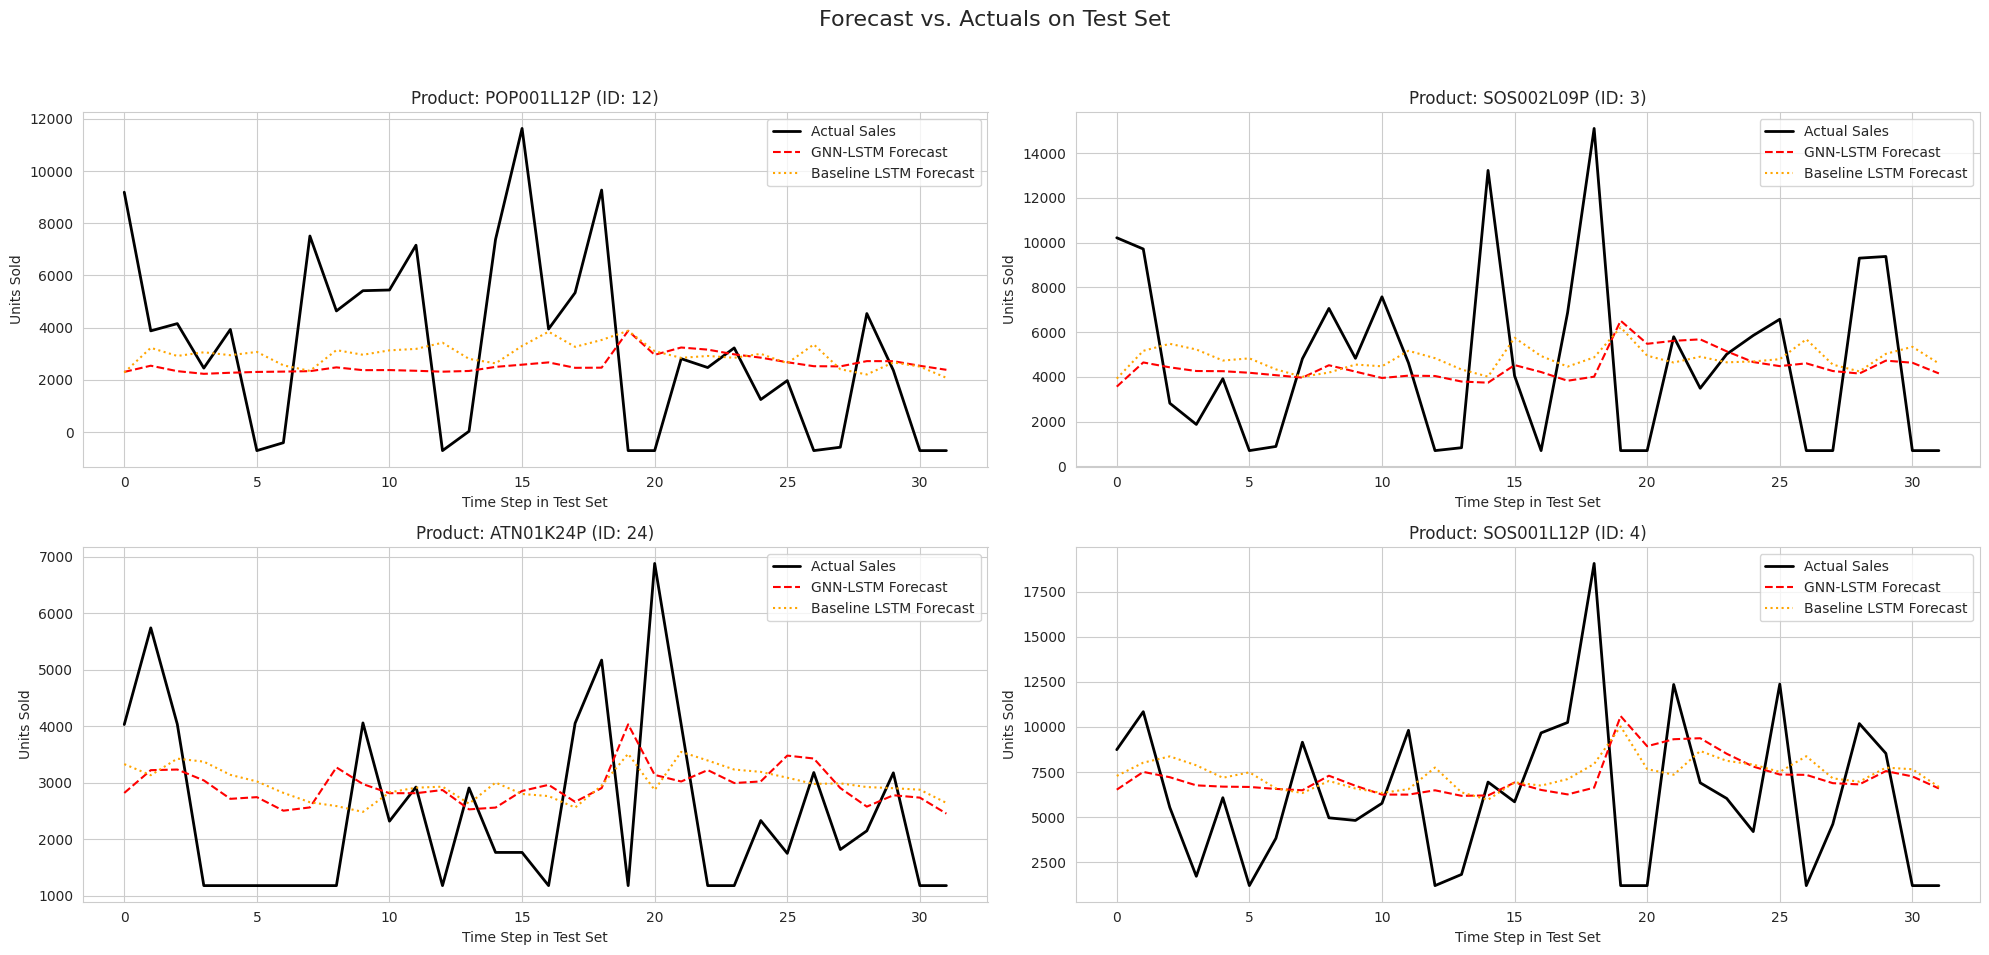

In [ ]:

@torch.no_grad()
def get_predictions(model, loader, static_features, edge_index_dict, is_gnn=True):
    model.eval()
    predictions, actuals = [], []
    for x_batch, y_batch in loader:
        x_batch = x_batch.to(DEVICE)
        if is_gnn:
            out = model(x_batch, static_features, edge_index_dict)
        else:
            out = model(x_batch)
        predictions.append(out.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(actuals)

static_feats = graph_data['product'].x.to(DEVICE)
edge_dict = {key: val.to(DEVICE) for key, val in graph_data.edge_index_dict.items()}

gnn_preds, gnn_actuals = get_predictions(gnn_model, test_loader, static_feats, edge_dict, is_gnn=True)
baseline_preds, baseline_actuals = get_predictions(baseline_model, test_loader, static_feats, edge_dict, is_gnn=False)

def inverse_transform_predictions(preds, scaler, num_nodes, target_feature_name):
    num_samples = preds.shape[0]
    dummy_array = np.zeros((num_samples, num_nodes * num_features_per_node))

    target_indices = [i for i, col in enumerate(scaled_df.columns) if col.startswith(target_feature_name)]
    if len(target_indices) != preds.shape[1]:
        print("Warning: Shape mismatch during inverse transform. This might indicate an issue.")
        return preds

    dummy_array[:, target_indices] = preds
    inversed_array = scaler.inverse_transform(dummy_array)
    return inversed_array[:, target_indices]

gnn_preds_orig = inverse_transform_predictions(gnn_preds, scaler, num_nodes, target_feature)
gnn_actuals_orig = inverse_transform_predictions(gnn_actuals, scaler, num_nodes, target_feature)
baseline_preds_orig = inverse_transform_predictions(baseline_preds, scaler, num_nodes, target_feature)

def print_metrics(model_name, preds, actuals):
    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    print(f"\nMetrics for {model_name}:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")

print_metrics("GNN-LSTM", gnn_preds_orig, gnn_actuals_orig)
print_metrics("Baseline LSTM", baseline_preds_orig, gnn_actuals_orig)

plt.figure(figsize=(20, 10))
plt.suptitle("Forecast vs. Actuals on Test Set", fontsize=16)
num_plots = 4
active_nodes = gnn_actuals_orig.mean(axis=0).argsort()[-num_plots*2:]
sample_node_indices = np.random.choice(active_nodes, num_plots, replace=False)

for i, node_idx in enumerate(sample_node_indices):
    plt.subplot(2, 2, i + 1)
    plt.plot(gnn_actuals_orig[:, node_idx], label='Actual Sales', color='black', linewidth=2)
    plt.plot(gnn_preds_orig[:, node_idx], label='GNN-LSTM Forecast', color='red', linestyle='--')
    plt.plot(baseline_preds_orig[:, node_idx], label='Baseline LSTM Forecast', color='orange', linestyle=':')
    node_name = nodes_df.loc[node_idx, 'node_name']
    plt.title(f"Product: {node_name} (ID: {node_idx})")
    plt.xlabel("Time Step in Test Set")
    plt.ylabel("Units Sold")
    plt.legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()